In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
import pandas as pd
from tqdm import tqdm
import functions as f
from pathlib import Path

In [2]:
t = 20
X, Y, VX, VY, RHO = np.load(f'./../simulation/simulation/output_npy/data_{t}.npy')
FIG_DIR = Path('./../figures/')

In [3]:
beta = np.deg2rad(30)
i    = np.deg2rad(50)
to_Myr = 9.78462

In [4]:
VX, VY = f.add_solid_body_rotation(X, Y, VX, VY, 0.4)
X, Y, VX, VY = f.rotate_bar(beta, X, Y, VX, VY)
X, Y, VR = f.incline_galaxy(i, X, Y, VX, VY)

Text(0.5, 1.0, '$V_{radial}$')

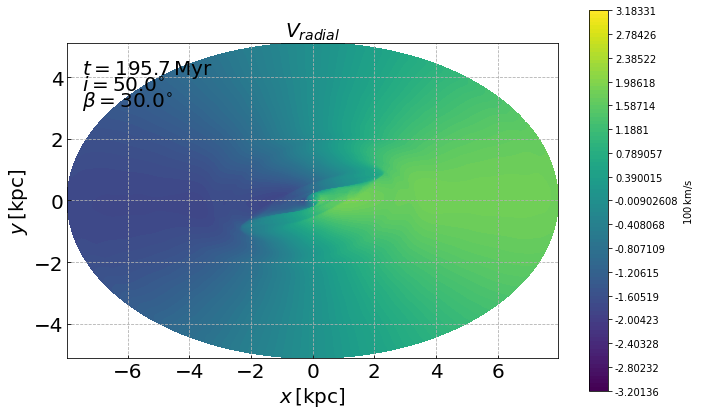

In [5]:
fig, ax = plt.subplots(figsize=(11, 7), sharex=True, sharey=True)
levels = np.linspace(VX.min(), VX.max(), 101)
cbarticks = np.linspace(VX.min(), VX.max(), 17)
norm = mc.BoundaryNorm(levels, 256)
im1 = ax.contourf(X, Y, VR, norm=norm, levels=levels, cmap='viridis')
ax.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr),
            xy=(0.03, 0.90), xycoords='axes fraction', fontsize=20, color='k')
ax.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)),
            xy=(0.03, 0.85), xycoords='axes fraction', fontsize=20, color='k')
ax.annotate(r'$\beta=%.1f ^{\circ}$' % (np.rad2deg(beta)),
            xy=(0.03, 0.80), xycoords='axes fraction', fontsize=20, color='k')

plt.colorbar(im1,ticks=cbarticks, format='%g', label=r'$\rm 100\, km/s$')

ax.grid(ls='dashed')
ax.tick_params(labelsize=20, direction='in')
ax.set_xlabel(r'$x\, \rm [kpc]$', fontsize=20)
ax.set_ylabel(r'$y\, \rm [kpc]$', fontsize=20)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_aspect('1')
ax.set_title(r'$V_{radial}$', fontsize=20)

In [6]:
pixels = pd.DataFrame()
VR_array = []
VR_weighted_array = []
x_center_array = []
y_center_array = []
x_weighted_array = []
y_weighted_array = []
step = 0.1


bounds_x = np.arange(-8, 8, step=step)
bounds_y = np.arange(Y.min().round(1), Y.max().round(1), step=step)
for left_bound_x in tqdm(bounds_x):
    for left_bound_y in bounds_y:
        mask = (X >= left_bound_x) & (X < left_bound_x + step) & (Y >= left_bound_y) & (Y < left_bound_y + step)
        x_center_array.append(left_bound_x + step / 2)
        y_center_array.append(left_bound_y + step / 2)
        if mask.sum() > 0:
            VR_ = (VR[mask]).sum() / (mask.sum()) 
            VR_weighted = (VR[mask] * RHO[mask]).sum() / (mask.sum()) 
            x_weighted  = (X[mask] * RHO[mask]).sum() / (mask.sum())
            y_weighted  = (Y[mask] * RHO[mask]).sum() / (mask.sum())
        else: VR_weighted = VR_ = x_weighted = y_weighted = np.nan
        VR_weighted_array.append(VR_weighted)
        VR_array.append(VR_)
        x_weighted_array.append(x_weighted)
        y_weighted_array.append(y_weighted)
        

100%|██████████| 160/160 [02:27<00:00,  1.08it/s]


In [7]:
pixels['VR_weighted'] = VR_weighted_array
pixels['VR'] = VR_array
pixels['x_weighted'] = x_weighted_array
pixels['y_weighted'] = y_weighted_array
pixels['x_center'] = x_center_array
pixels['y_center'] = y_center_array

In [8]:
pixels.dropna(how='any', inplace=True)

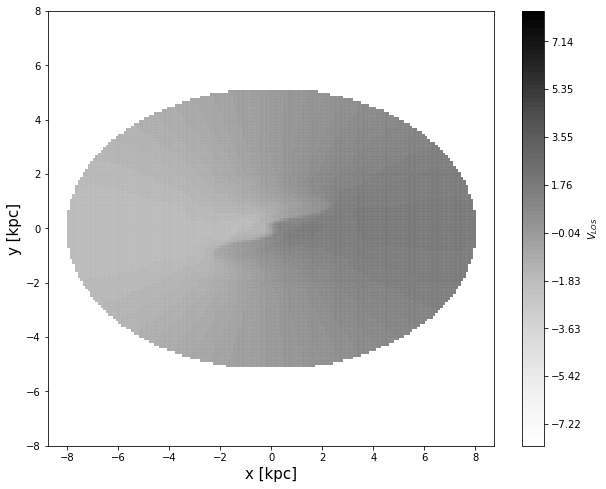

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

levels = np.linspace(pixels['VR_weighted'].min(), pixels['VR_weighted'].max(), 101)
norm = mc.BoundaryNorm(levels, 256)

sc = ax.scatter(pixels['x_center'], pixels['y_center'], c=pixels['VR'], 
                cmap='Greys',norm=norm, marker='s', s=3)
ax.set_xlabel('x [kpc]', fontsize=15)
ax.set_ylabel('y [kpc]', fontsize=15)
ax.set_ylim(-8, 8)
plt.colorbar(sc, label=r'$V_{LOS}$')

In [11]:
# integrating

In [12]:
TW_method = pd.DataFrame(data={'y':np.unique(pixels['y_center'].values)})

In [13]:
vr_average = []
x_average = []
for y in TW_method['y']:
    mask = (pixels['y_center'] == y)
    vr_average.append(pixels['VR_weighted'][mask].mean())
    x_average.append(pixels['x_weighted'][mask].mean())

In [14]:
TW_method['VR_weighted'] = vr_average
TW_method['x_weighted'] = x_average

In [15]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021/bin/universal-darwin'
#print(os.getenv("PATH"))

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=True)


In [16]:
plasma = cm.get_cmap('plasma', len(TW_method))
colors = plasma.colors

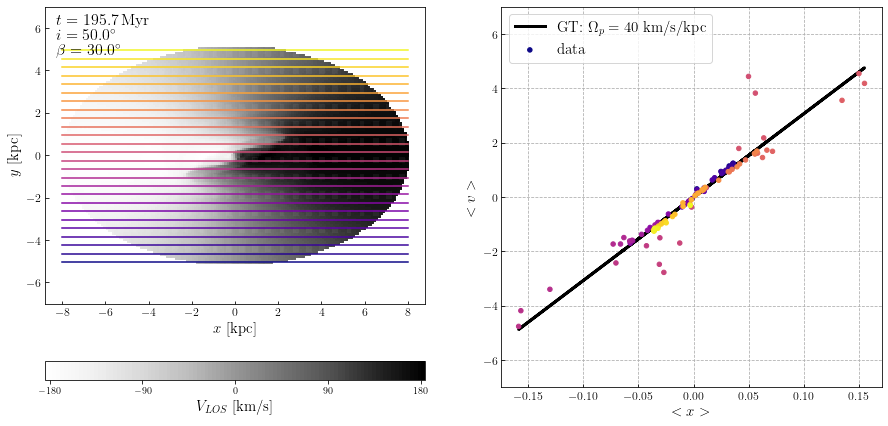

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

levels = np.linspace(pixels['VR'].min() * 100, pixels['VR'].max() * 100, 101)
cbarticks = np.linspace(pixels['VR'].min().round(1) * 100, pixels['VR'].max().round(1) * 100, 5)
norm = mc.BoundaryNorm(levels, 256)

ax1 = ax[0]
ax2 = ax[1]

sc = ax1.scatter(pixels['x_center'], pixels['y_center'], c=pixels['VR'] * 100, 
                 cmap='Greys', norm=norm, marker='s', s=3)
for index, y in enumerate(TW_method['y']):
    if index % 4 == 0:
        ax1.plot([-8, 8], [y, y], c=colors[index])
ax1.set_xlabel(r'$x$ [kpc]', fontsize=15)
ax1.set_ylabel(r'$y$ [kpc]', fontsize=15)
ax1.tick_params(labelsize=12, direction='in')
ax1.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr), xy=(0.03, 0.94),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)), xy=(0.03, 0.89),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$\beta=%.1f ^{\circ}$' % (np.rad2deg(beta)), xy=(0.03, 0.84),
             xycoords='axes fraction', fontsize=16, color='k')

ax1.set_ylim(-7, 7)
cbar = plt.colorbar(sc, ax=ax1, orientation="horizontal", fraction=0.07, ticks=cbarticks)
cbar.set_label(label=r'$V_{LOS}$ [km/s]', size=15)


ax2.scatter(TW_method['x_weighted'], TW_method['VR_weighted'] * 100, s=20, c=colors, label=r'data', zorder=100)
ax2.plot(TW_method['x_weighted'], TW_method['x_weighted'] * 40 * np.sin(i),
         c='black', lw=3, label=r'GT: $\Omega_p = 40$ km/s/kpc')

ax2.set_ylim(-7, 7)
ax2.tick_params(labelsize=12,direction='in')
ax2.set_xlabel(r'$<x>$', fontsize=15)
ax2.set_ylabel(r'$<v>$', fontsize=15)
ax2.legend(fontsize=15, loc='upper left')
ax2.grid(ls='dashed')
plt.savefig(FIG_DIR / 'TW_method.png', bbox_inches='tight', dpi=300)